[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/krasserm/bayesian-machine-learning/blob/master/bayesian_optimization.ipynb)

## Experiment 3.4.1
## Bayesian optimization for (noisy) function approximation

The objective function is $f(x) = -cos(5x) + 0.4x^2 + 0.4x$,
but it is not 'observed'. Instead, we have noisy samples of it, and since it is unknown in practice, we can say this $f(x)$ is black box.


Source: https://github.com/krasserm/bayesian-machine-learning.git


In [0]:
try:
    # Check if notebook is running in Google Colab
    import google.colab
    # Get additional files from Github
    !wget https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/master/bayesian_optimization_util.py
    # Install additional dependencies
    !pip install scikit-optimize==0.5.2
    !pip install GPy==1.9.8
    !pip install GPyOpt==1.2.1
    !pip install xgboost==0.90
except:
    pass

In [0]:
import numpy as np

%matplotlib inline

bounds = np.array([[-1.0, 1.0]])
noise = 0.1

def f(X, noise=noise):
    return -np.cos(5*X) + 0.4*X**2 + 0.4*X + noise * np.random.randn(*X.shape) #-np.sin(3*X) - X**2 + 0.7*X

X_init = np.array([[-0.5], [0.5]])
Y_init = f(X_init)

The following plot shows the noise-free objective function, the amount of noise by plotting a large number of samples and the two initial samples.

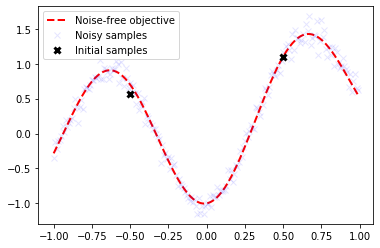

In [3]:
import matplotlib.pyplot as plt

# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'r--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

The goal is to find the 'global' maximum on the right in a small number of steps. (Note: 'global' because the domain space is restricted; the function's true global maximum may be outside of this space).

In [0]:
from scipy.stats import norm
from warnings import catch_warnings, simplefilter

def surrogate(gpr, X, return_std):
  '''
  This function uses gpr as a GP regression acting as a surrogate for the 
  posterior.
  '''
	# catch any warning generated when making a prediction
  with catch_warnings():
    # ignore generated warnings
    simplefilter("ignore")
    return gpr.predict(X, return_std=return_std)

#We need to add other acquisition functions here, for future consideration in experiments

def lower_confidence_bound(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the maximum probability of improvement at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which prob. of improvement shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = surrogate(gpr, X, return_std=True)
    mu_sample = surrogate(gpr, X_sample, return_std=False)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [...]

    #minimize regret
    mu_sample_opt = np.max(mu_sample)

    lcb = mu_sample_opt - xi*sigma
    return lcb

def max_probability_of_improvement(X, X_sample, Y_sample, gpr, xi=0.01):

    '''
    Computes the maximum probability of improvement at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which prob. of improvement shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = surrogate(gpr, X, return_std=True)
    mu_sample = surrogate(gpr, X_sample, return_std=False)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [...]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        pi = norm.cdf(Z)
    return pi

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = surrogate(gpr, X, return_std=True)
    mu_sample = surrogate(gpr, X_sample, return_std=False)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [...]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei


The 'propose_location' function maximizes the acquisition function of choice (via the L-BFGS algorithm), in order to suggest the next sample $x_{new}$. Note that this is *myopic*: it only suggests **one** $x_{new}$, without regard for what may come after.

In [0]:
from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

The Gaussian process in the following example is configured with a *Matérn* kernel, which is a generalization of the *squared exponential* kernel. 

Bayesian optimization is run for 20 iterations (convergence looks pretty good, although some user-defined threshold can be defined for which the algorithm will stop if it goes beyond). 

In each iteration, a row with two plots is produced. The left plot shows the noise-free objective function, the surrogate function which is the GP posterior predictive mean, the 95% confidence interval of the mean and the noisy samples obtained from the objective function so far. The right plot shows the acquisition function. The vertical dashed line in both plots shows the proposed sampling point for the next iteration which corresponds to the maximum of the acquisition function.

The *epistemic* uncertainty is captured in each iteration as the predictive posterior variance for the new input $x_{new}$, while the aleatoric is well-approximated by the variance of the additive noise terms as in Hüllermeier et al (2019).




[1.] [0.52967265]
[0.30999258] [0.12425987]
[0.98943954] [0.46074583]
[-0.98407504] [-0.26556748]
[0.61381384] [1.44751432]
[0.62074753] [1.31808781]
[0.62292841] [1.38286265]
[0.62770005] [1.55009417]
[0.65140129] [1.36631418]
[0.63076617] [1.40799928]
[0.62487693] [1.37805112]
[0.67172842] [1.45772012]
[0.67288565] [1.26097618]
[0.6023765] [1.22718751]
[0.66401877] [1.24910315]
[0.60395401] [1.30298794]
[0.61458497] [1.37904839]
[0.66957297] [1.54480978]
[0.68525444] [1.40374819]
[0.6821739] [1.62094791]


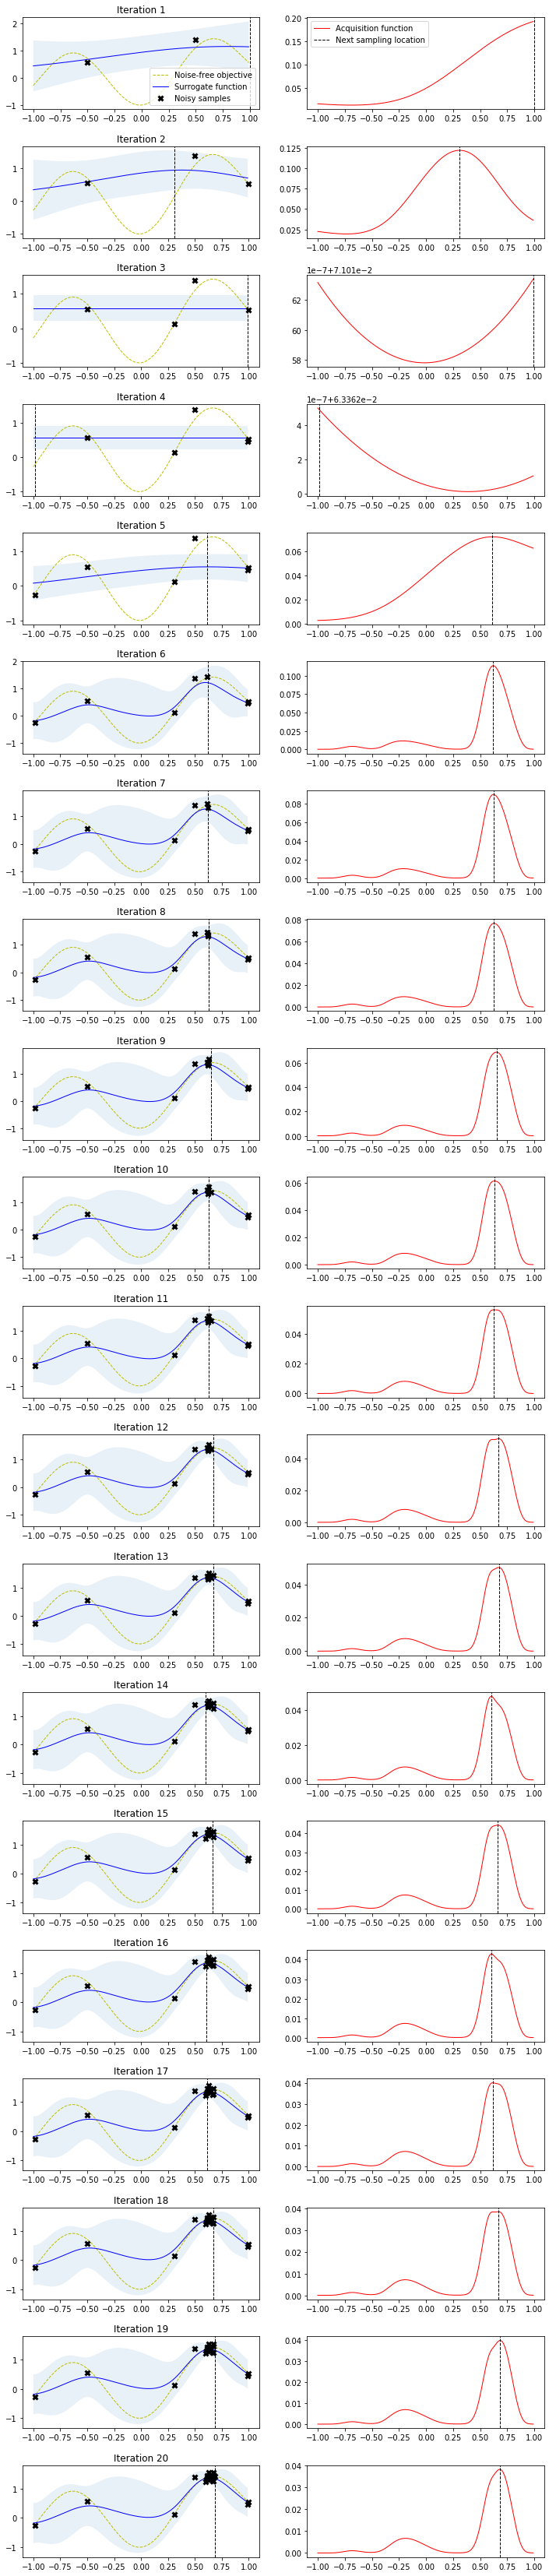

In [0]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition



# Gaussian process with Matérn kernel as surrogate model
#define a schedule for the Matern kernel. Generally nu = 3/2 and 5/2
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise_scale**2)

bounds = np.array([[-1.0, 1.0]])


def f(X, noise=noise_scale):
    return -np.cos(5*X) + 0.4*X**2 + 0.4*X + noise_scale * np.random.randn(*X.shape), noise_scale * np.random.randn(*X.shape)
    
#-np.sin(3*X) - X**2 + 0.7*X

X_init = np.array([[-0.5], [0.5]])
Y_init, _ = f(X_init) #noise less

# Initialize samples
X_sample = X_init
Y_sample = Y_init
noise_scale = 0.1

# Number of iterations
n_iter = 20

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)
noise_magnitude_per_observation = [] #the variance of the noise variance acts as a good measure of aleatoric uncertainty
epistemic_per_observation = []

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)
    posterior_mu, posterior_sigma = surrogate(gpr, X_sample, return_std=True)

    
    # Obtain next sampling point from the acquisition function {expected_improvement, max_probability_of_improvement}
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    epistemic = posterior_sigma**2
    #print(epistemic[-1])
    epistemic_per_observation.append(epistemic[-1])
    #print(X_next)
    # Obtain next noisy sample from the objective function
    #noise = noise_scale * np.random.randn(*X.shape) 
    
    Y_next, noise_magnitude = f(X_next, noise_scale)
    
    noise_magnitude_per_observation.append(noise_magnitude.item())
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    #print posterior variance
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))
    #print(X_sample[-1], Y_sample[-1])

In [0]:
aleatoric = np.var(noise_magnitude_per_observation)
print(epistemic_per_observation)
print(aleatoric)

[-0.0486041819329692, -0.23851556511724215, -0.018847305101928377, -0.02002289288585926, 0.09050318310218192, -0.058864280533340946, -0.024988589532240743, -0.0019453862095365664, -0.08713150590436769, -0.16894537645753085, 0.15064163301751143, 0.08114951670887927, -0.09232449649483265, 0.11353726800107718, -0.07418303632704967, 0.06080192326264631, -0.11894746917398216, 0.01244817470839801, -0.022387485245234037, 0.21174989332075844]
[0.116073848133312, 0.09268312547417314, 0.036206858827996624, 0.02926365886363352, 0.06368160442432416, 0.08797403614765997, 0.05781529218278436, 0.04292939587541733, 0.03485640257945016, 0.03401219313428783, 0.02413379607557509, 0.02050589916759071, 0.0284336613619729, 0.024281112077653766, 0.01725768350992585, 0.01799408864598956, 0.014748184798019868, 0.012335255218519138, 0.016413887676452302, 0.018758468700672163]
0.011235695708227935


Represent the epistemic uncertainty, and relate it to exploration. Looking at epistemic uncertainty over the iterations is a good way of gauging whether the data is explaining away the uncertainty.


 Notice that it also slightly correlates to the *'Distance between consecutive x's'* plot below which is a good visual representation of exploration.

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


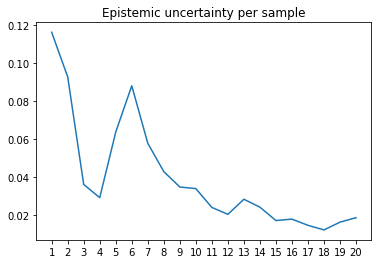

In [0]:
sample_index = np.array([i for i in range(21)])[1:]
#print(sample_index)
plt.xticks(sample_index)
plt.title("Epistemic uncertainty per sample")
plt.plot(sample_index, epistemic_per_observation)



A convergence plot reveals how many iterations are needed the find a maximum and if the sampling point proposals stay around that maximum i.e. converge to small proposal differences between consecutive steps. 

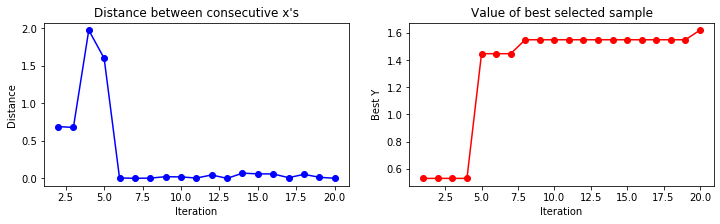

In [0]:
from bayesian_optimization_util import plot_convergence

plot_convergence(X_sample, Y_sample)

## Bayesian optimization libraries



### Scikit-optimize


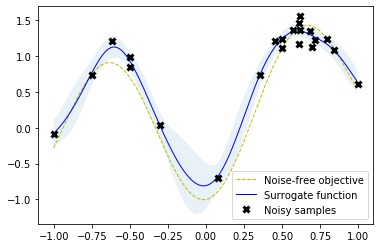

In [0]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

# Use custom kernel and estimator to match previous example
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

def f(X, noise=noise_scale):
    return -np.cos(5*X) + 0.4*X**2 + 0.4*X + noise_scale * np.random.randn(*X.shape)

r = gp_minimize(lambda x: -f(np.array(x))[0], 
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=20,         # number of iterations
                n_random_starts=0,  # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=-Y_init.ravel())

# Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

# Plot the fitted model and the noisy samples
plot_approximation(gpr, X, Y, r.x_iters, -r.func_vals, show_legend=True)

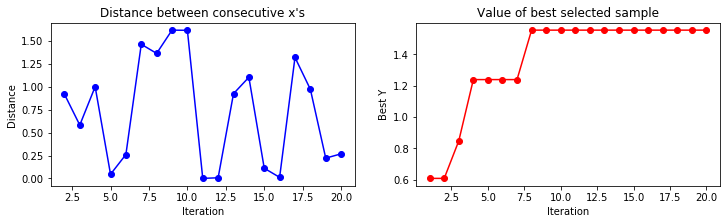

In [0]:
plot_convergence(np.array(r.x_iters), -r.func_vals)

## GPyOpt



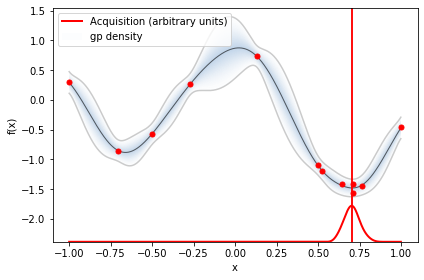

In [9]:
import GPy
import GPyOpt

from GPyOpt.methods import BayesianOptimization

kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
bds = [{'name': 'X', 'type': 'continuous', 'domain': bounds.ravel()}]

optimizer = BayesianOptimization(f=f, 
                                 domain=bds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.1,
                                 X=X_init,
                                 Y=-Y_init,
                                 noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True)

optimizer.run_optimization(max_iter=10)
optimizer.plot_acquisition()

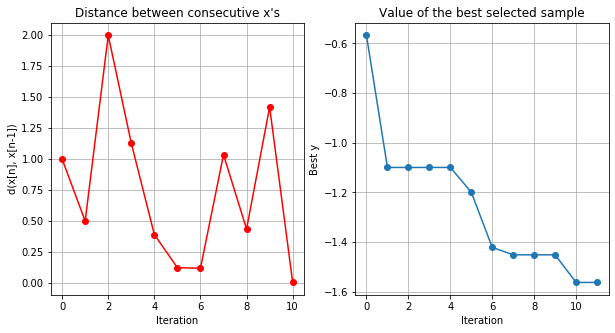

In [10]:
optimizer.plot_convergence()

## References

\[1\] Eric Brochu, Vlad M. Cora, Nando de Freitas, [A Tutorial on Bayesian Optimization of Expensive Cost Functions](https://arxiv.org/abs/1012.2599).  
\[2\] Jonas Mockus, [Application of Bayesian approach to numerical methods of global and stochastic optimization](https://link.springer.com/article/10.1007/BF01099263).  
\[3\] Donald R. JonesMatthias SchonlauWilliam J. Welch, [Efficient Global Optimization of Expensive Black-Box Functions](https://link.springer.com/article/10.1023/A:1008306431147).  
\[4\] Jialei Wang, Scott C. Clark, Eric Liu, Peter I. Frazier, [Parallel Bayesian Global Optimization of Expensive Functions](https://arxiv.org/abs/1602.05149).  